In [1]:
from __future__ import print_function, division
import os

import torch
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage import io, transform
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET
from copy import deepcopy
import random

from moviepy.editor import VideoFileClip,ImageSequenceClip
from IPython.display import HTML
import matplotlib.image as mpimg

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import cv2
from matplotlib import gridspec

import pickle
from pylab import *
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
cdict = {'red': ((0.0, 1.0, 1.0),
                 (0.125, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5625, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5625, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 0.0, 0.0),
                  (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

%matplotlib inline
# %matplotlib notebook

In [2]:
output_single_sensor = False
use_volume_and_occup = False
use_weather = False
use_history = True
input_feature = 'cnn'
weights_file_name = 'Speedonly_with_history'

In [3]:
class LSTM_SpeedPrediction_database_output_single_sensor(Dataset):
    def __init__(self, Traffic, Weather, data, transform=None, look_back = 6, target_sensor = 13):

        self.Traffic = Traffic
        self.Weather = Weather
        self.data = data
        self.transform = transform
        self.look_back = look_back
        self.target_sensor = target_sensor
#         print(self.__len__())
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        assert idx < self.__len__(),'idx out of dataset index boundary'
        
        Traffic_today = self.Traffic[idx,:,:-1,:]
        Weather_today = self.Weather[idx,:,:-1,:]
        Traffic_history = 0
        Traffic_output = self.Traffic[idx,self.target_sensor,1:,0]
        
        dayofweek = self.data.loc[idx]['dayofweek']
        data_sub = self.data[:idx]
        sameday_in_history = data_sub.index[data_sub['dlen(sameday_in_history)ayofweek'] == dayofweek].tolist()
        
        Traffic_history = np.full((self.look_back,)+self.Traffic.shape[1:], np.nan)
#         print(len(sameday_in_history))
        sameday_in_near_history = sameday_in_history[-self.look_back:]
#         print(len(sameday_in_near_history))
        
        for i in range(len(sameday_in_near_history)):
            Traffic_history[i] = self.Traffic[sameday_in_near_history[i]]
        
        sample = {'traffic': Traffic_today, 'weather': Weather_today, 'history': Traffic_history, 'label': Traffic_output}

        if self.transform:
            sample = self.transform(sample)
        return sample
     
class LSTM_SpeedPrediction_database_output_multi_sensor(Dataset):
    def __init__(self, Traffic, Weather, data, transform=None, look_back = 6):

        self.Traffic = Traffic
        self.Weather = Weather
        self.data = data
        self.transform = transform
        self.look_back = look_back
#         printdb_trans_1 = Dataset_NVIDIA_1(annotation_list,frame_list,transform = PerspectiveTransform(MAP_FILE, world_origin, pixel_ratio, PMAT_FILE))(self.__len__())
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        assert idx < self.__len__(),'idx out of dataset index boundary'
        Traffic_today = self.Traffic[idx,:,:-1,:]
        Weather_today = self.Weather[idx,:,:-1,:]
        Traffic_history = 0 
        Traffic_output = self.Traffic[idx,:,1:,0]
        
        dayofweek = self.data.loc[idx]['dayofweek']
        data_sub = self.data[:idx]
        sameday_in_history = data_sub.index[data_sub['dayofweek'] == dayofweek].tolist()
        
#         Traffic_history = np.full((self.look_back,)+self.Traffic.shape[1:], np.nan)
        
        Traffic_history = [self.Traffic[idx,:,:,:]+np.random.randn(15,1440,3) for _ in range(self.look_back)]
        Traffic_history = np.stack(Traffic_history,0)
        
#         print(len(sameday_in_history))
        sameday_in_near_history = sameday_in_history[-self.look_back:]
#         print(len(sameday_in_near_history))
        
        for i in range(len(sameday_in_near_history)):
            Traffic_history[self.look_back-len(sameday_in_near_history)+i] = self.Traffic[sameday_in_near_history[i]]
        
        sample = {'traffic': torch.Tensor(Traffic_today),'weather': torch.Tensor(Weather_today), 'history': torch.Tensor(Traffic_history), 'label': torch.Tensor(Traffic_output)} # 

        if self.transform:
            sample = self.transform(sample)
        return sample

In [4]:
''''''
which_data = 'Data_2015_DES_I235E'
(Traffic_2015,Weather_2015,data_2015) = pickle.load( open(which_data+"_filter_smooth.p", "rb" ) )
year =  data_2015['y'][0][:4]
print('{} data loaded'.format(year))

which_data = 'Data_2016_DES_I235E'
(Traffic_2016,Weather_2016,data_2016) = pickle.load( open(which_data+"_filter_smooth.p", "rb" ) )
year =  data_2016['y'][0][:4]
print('{} data loaded'.format(year))

data = pd.concat([data_2015,data_2016],ignore_index=True)
Traffic = np.concatenate([Traffic_2015, Traffic_2016],axis = 0)
Weather_5min = np.concatenate([Weather_2015, Weather_2016],axis = 0)
Weather = np.zeros([Weather_5min.shape[0],Weather_5min.shape[1],Weather_5min.shape[2]*5,Weather_5min.shape[3]])
for i in range(Weather.shape[2]):
    Weather[:,:,i,:] = Weather_5min[:,:,int(i/5),:]
Weather = np.delete(Weather,1,axis=3)


db = LSTM_SpeedPrediction_database_output_multi_sensor(Traffic, Weather, data)
print('database "db" built from file')

Traffic_max = []
Traffic_min = []
Weather_max = []
Weather_min = []

for i in range(Traffic.shape[-1]):
    Traffic_max.append(np.max(Traffic[:,:,:,i]))
    Traffic_min.append(np.min(Traffic[:,:,:,i]))
for i in range(Weather.shape[-1]):
    Weather_max.append(np.max(Weather[:,:,:,i]))
    Weather_min.append(np.min(Weather[:,:,:,i]))
    
Min_Max = (Traffic_max,Traffic_min,Weather_max,Weather_min)

loss_log = pickle.load( open('loss_log_'+weights_file_name+'_.p', "rb" ) )
print('training log loaded into loss_log')
''''''

2015 data loaded
2016 data loaded
database "db" built from file
training log loaded into loss_log


''

In [5]:
class LSTM_Short_Term_Speed_Pred_Net(nn.Module):
    def __init__(self, filter_height = 5, output_single_sensor = False, \
                 hidden_dim = 16,use_gpu = True, use_volume_and_occup = False, \
                 use_weather = False, use_history = True, input_feature = 'cnn', Min_Max = Min_Max):
        super(LSTM_Short_Term_Speed_Pred_Net, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.out_dim = 15
        
        self.input_dim_today = self.out_dim
        self.input_dim_history = self.out_dim
        if input_feature == 'cnn':
            self.input_dim_today = self.out_dim - filter_height + 1
            self.input_dim_history = self.out_dim - filter_height + 1
#         else:
#             self.input_dim_today = self.out_dim
#             self.input_dim_history = self.out_dim
        
        if output_single_sensor:
            self.out_dim = out_dim = 1
        self.use_gpu = use_gpu
        
        self.use_volume_and_occup = use_volume_and_occup
        self.use_weather = use_weather
        self.use_history = use_history
#         assert input_feature in ['raw','linear','cnn'], 'wrong choice for input_feature'
        assert input_feature == 'cnn', 'currently only allow cnn as input feature extractor'
        self.input_feature = input_feature # ['raw','linear','CNN']
        
        '''for on-fly normalization'''
        self.Traffic_max = Min_Max[0]
        self.Traffic_min = Min_Max[1]
        self.Weather_max = Min_Max[2]
        self.Weather_min = Min_Max[3]
        
        if self.input_feature == 'cnn':
            self.CNN_feature_extract = nn.Conv2d(1, 1, (filter_height, 1), stride=(1, 1))
            self.CNN_for_history = self.CNN_feature_extract
            if self.use_volume_and_occup:
                self.CNN_feature_extract = nn.Conv2d(1, 1, (filter_height, 3), stride=(1, 1))
            if self.use_weather:
                self.CNN_feature_extract = nn.Conv2d(1, 1, (filter_height, 12), stride=(1, 1))
        self.CNN_today_and_history_output_combine = nn.Conv2d(1, 1, (1, 2), stride=(1, 1))
        self.lstm_today = nn.LSTMCell(self.input_dim_today, self.hidden_dim)
        self.lstm_history = nn.LSTMCell(self.input_dim_history, self.hidden_dim)
        self.linear_out = nn.Linear(self.hidden_dim, self.out_dim)
        
    def init_hidden(self,input_sample):
        
        batch_size = input_sample['traffic'].shape[0]
        if self.use_gpu:
            return Variable(torch.zeros(batch_size, self.hidden_dim).cuda(), requires_grad=False)
        return Variable(torch.zeros(batch_size, self.hidden_dim), requires_grad=False)

    def LSTM_update(self,input_t,hidden_state_today,cell_state_today):
        input_t = input_t.squeeze(3).squeeze(1)
        hidden_state_today, cell_state_today = self.lstm_today(input_t, (hidden_state_today, cell_state_today))
        hidden_state_output = hidden_state_today
        return hidden_state_today, cell_state_today, hidden_state_output
 
    def LSTM_update_with_history(self,input_t,input_history,hidden_state_today,cell_state_today,hidden_state_history,cell_state_history):
        input_t = input_t.squeeze(3).squeeze(1)
        hidden_state_today, cell_state_today = self.lstm_today(input_t, (hidden_state_today, cell_state_today))
        if len(input_history)>0:
            for input_t_history in input_history:
                input_h = input_t_history.squeeze(3).squeeze(1)
                hidden_state_history, cell_state_history = self.lstm_history(input_h, (hidden_state_history, cell_state_history))

            h_combine = torch.stack([hidden_state_today,hidden_state_history],2)
            h_combine = h_combine.unsqueeze(1)
            hidden_state_output = self.CNN_today_and_history_output_combine(h_combine)
            hidden_state_output = hidden_state_output.squeeze(3).squeeze(1)
            return hidden_state_today, cell_state_today, hidden_state_output
        else:
            hidden_state_output = hidden_state_today
            return hidden_state_today, cell_state_today, hidden_state_output
        

    def forward(self, input_sample, future = 0, use_gpu = True):
        
        '''reconstruct data from sample'''
        traffic = input_sample['traffic']
        weather = input_sample['weather']
        history = input_sample['history']
        label = input_sample['label']
        
        '''normalize'''
#         label = (label - self.Traffic_min[0])/(self.Traffic_max[0]-self.Traffic_min[0])
        for i in range(traffic.shape[-1]):
            traffic[:,:,:,i] = (traffic[:,:,:,i]-self.Traffic_min[i])/(self.Traffic_max[i]-self.Traffic_min[i])
            history[:,:,:,:,i] = (history[:,:,:,:,i]-self.Traffic_min[i])/(self.Traffic_max[i]-self.Traffic_min[i])
        for i in range(weather.shape[-1]):
            weather[:,:,:,i] = (weather[:,:,:,i]-self.Weather_min[i])/(self.Weather_max[i]-self.Weather_min[i])
        
        '''re-arrange inputs'''
        input_today = traffic[:,:,:,0:1]
        
        if self.use_volume_and_occup:
            input_today = traffic
            
        if self.use_weather:
            input_today = torch.cat([traffic,weather],3)
            
        input_history = history[:,:,:,:,0:1]
            
        if use_gpu:
            input_today = Variable(input_today.cuda())
            input_history = Variable(input_history.cuda())
            label = Variable(label.cuda())
        else:
            input_today = Variable(input_today)
            input_history = Variable(input_history)
            label = Variable(label)
        
        '''feedforward'''
        
        outputs = []
        hidden_state_today = self.init_hidden(input_sample)
        cell_state_today = self.init_hidden(input_sample)
        hidden_state_history = self.init_hidden(input_sample)
        cell_state_history = self.init_hidden(input_sample)
#         print(input_today.data.shape[2])
        for i in range(input_today.data.shape[2]):
            
            input_t = input_today[:,:,i:i+1,:]
            input_t = input_t.permute(0,2,1,3)
            
            input_t_history = []
#             print(input_history.shape[1])
            for k in range(input_history.shape[1]):
                if not np.isnan(np.array(input_history[0,k,0,0,0].data))[0]:
                    input_t_history.append(input_history[:,k,:,i+1:i+2,:].permute(0,2,1,3))
#             print(len(input_t_history))

            if self.input_feature == 'cnn':
                input_t = self.CNN_feature_extract(input_t)
                input_t_history = [self.CNN_for_history(x) for x in input_t_history]

            if self.use_history:
                hidden_state_today, cell_state_today, hidden_state_output = self.LSTM_update_with_history(input_t,input_t_history,hidden_state_today,cell_state_today,hidden_state_history,cell_state_history)
            else:
                hidden_state_today, cell_state_today, hidden_state_output = self.LSTM_update(input_t,hidden_state_today,cell_state_today)
            
            output = nn.functional.sigmoid(self.linear_out(hidden_state_output))
            output = output*(self.Traffic_max[0]-self.Traffic_min[0])+self.Traffic_min[0] 
            outputs += [output]
        outputs = torch.stack(outputs, 2)

        return outputs, label

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
use_gpu = torch.cuda.is_available()

model = LSTM_Short_Term_Speed_Pred_Net(filter_height = 5, output_single_sensor = output_single_sensor, \
                 hidden_dim = 16,use_gpu = use_gpu, use_volume_and_occup = use_volume_and_occup, \
                 use_weather = use_weather, use_history = use_history, input_feature = input_feature)
print('model structure built from class')
if use_gpu:
    model = model.cuda()

model.load_state_dict(torch.load(weights_file_name))
print('model weights loaded from {}'.format(weights_file_name))

model structure built from class
model weights loaded from Speedonly_with_history


X                      20161216Dir1.csv
y             20161216_Traffic_Dir1.csv
day                            20161216
date                2016-12-16 00:00:00
dayofweek                             4
weekofyear                           50
month                                12
dayofyear                           351
Name: 431, dtype: object
<class 'torch.FloatTensor'>
dict_keys(['history', 'label', 'traffic', 'weather'])
db[idx]["traffic"].shape:  torch.Size([15, 1439, 3])
db[idx]["weather"].shape:  torch.Size([15, 1439, 9])
db[idx]["history"].shape:  torch.Size([6, 15, 1440, 3])
db[idx]["label"].shape:  torch.Size([15, 1439])


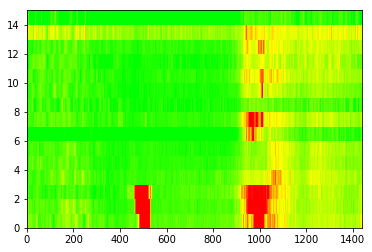

In [6]:
idx = 431  # test: [417,420,431]
print(data.loc[idx])

def vis_one_day_traffic_speed(speed):
    plt.pcolor(speed,cmap=my_cmap, vmin=20, vmax=70)
    
# vis_one_day_traffic_speed(db[257]['label'])
print(type(db[idx]['traffic']))
print(db[idx].keys())
print('db[idx]["traffic"].shape: ',db[idx]['traffic'].shape)
print('db[idx]["weather"].shape: ',db[idx]['weather'].shape)
print('db[idx]["history"].shape: ',db[idx]['history'].shape)
print('db[idx]["label"].shape: ',db[idx]['label'].shape)
vis_one_day_traffic_speed(db[idx]['traffic'][:,:,0]) 

In [7]:
def add_patch_dim_to_sample(sample):
    traffic = sample['traffic'].unsqueeze(0)
    weather = sample['weather'].unsqueeze(0)
    label = sample['label'].unsqueeze(0)
    history = sample['history'].unsqueeze(0)
    sample = {'traffic':traffic,'weather':weather,'label':label,'history':history}
    return sample

In [10]:
# out,label=model(add_patch_dim_to_sample(db[idx]))
# label = label.squeeze(0).data.cpu().numpy()
# out = out.squeeze(0).data.cpu().numpy()

In [11]:
# vis_one_day_traffic_speed(label) 

In [12]:
# vis_one_day_traffic_speed(out) 

In [8]:
def init_hidden():
        
    batch_size = 1
    hidden_dim = 16
    if use_gpu:
        return Variable(torch.zeros(batch_size, hidden_dim).cuda(), requires_grad=False)
    return Variable(torch.zeros(batch_size, hidden_dim), requires_grad=False)
    
def inference(input_sample,model,step_ahead,Min_Max=Min_Max):
    
    Traffic_max = Min_Max[0]
    Traffic_min = Min_Max[1]
    Weather_max = Min_Max[2]
    Weather_min = Min_Max[3]
    
    '''reconstruct data from sample'''
    traffic = input_sample['traffic']
    weather = input_sample['weather']
    history = input_sample['history']
    label = input_sample['label']
        
    '''normalize'''
#         label = (label - self.Traffic_min[0])/(self.Traffic_max[0]-self.Traffic_min[0])
    for i in range(traffic.shape[-1]):
        traffic[:,:,i] = (traffic[:,:,i]-Traffic_min[i])/(Traffic_max[i]-Traffic_min[i])
        history[:,:,:,i] = (history[:,:,:,i]-Traffic_min[i])/(Traffic_max[i]-Traffic_min[i])
    for i in range(weather.shape[-1]):
        weather[:,:,i] = (weather[:,:,i]-Weather_min[i])/(Weather_max[i]-Weather_min[i])
        
    '''re-arrange inputs'''
    input_today = traffic[:,:,0:1]
        
    if use_volume_and_occup:
        input_today = traffic
            
    if use_weather:
        input_today = torch.cat([traffic,weather],2)
            
    input_history = history[:,:,:,0:1]
            
    if use_gpu:
        input_today = Variable(input_today.cuda())
        input_history = Variable(input_history.cuda())
        label = Variable(label.cuda())
    else:
        input_today = Variable(input_today)
        input_history = Variable(input_history)
        label = Variable(label)
        
        '''feedforward'''
        
    outputs = []
    hidden_state_today = init_hidden()
    cell_state_today = init_hidden()
    hidden_state_history = init_hidden()
    cell_state_history = init_hidden()
#         print(input_today.data.shape[2])
    for i in range(input_today.data.shape[1]-step_ahead+1):
            
        input_t = input_today[:,i:i+1,:]
        input_t = input_t.unsqueeze(0)
        input_t = input_t.permute(0,2,1,3)
            
        input_t_history = []
#             print(input_history.shape[1])
        for k in range(input_history.shape[0]):
            input_t_history.append(input_history[k,:,i+1:i+2,:].unsqueeze(0).permute(0,2,1,3))

        input_t = model.CNN_feature_extract(input_t)
        input_t_history = [model.CNN_for_history(x) for x in input_t_history]

        if use_history:
            hidden_state_today, cell_state_today, hidden_state_output = model.LSTM_update_with_history(input_t,input_t_history,hidden_state_today,cell_state_today,hidden_state_history,cell_state_history)
        else:
            hidden_state_today, cell_state_today, hidden_state_output = model.LSTM_update(input_t,hidden_state_today,cell_state_today)
            
        hidden_state_today_pred = hidden_state_today.clone() 
        cell_state_today_pred = cell_state_today.clone()
        
        for j in range(step_ahead-1):
            pred_speed_as_input = nn.functional.sigmoid(model.linear_out(hidden_state_output))
            pred_speed_as_input = pred_speed_as_input.unsqueeze(2).unsqueeze(0)
            pred_feature_as_input = model.CNN_feature_extract(pred_speed_as_input)
            
            input_t_history = []
#             print(input_history.shape[1])
            for k in range(input_history.shape[0]):
                input_t_history.append(input_history[k,:,i+1+j+1:i+2+j+1,:].unsqueeze(0).permute(0,2,1,3))

            input_t_history = [model.CNN_for_history(x) for x in input_t_history]
            
            if use_history:
                hidden_state_today_pred, cell_state_today_pred, hidden_state_output = model.LSTM_update_with_history(pred_feature_as_input,input_t_history,hidden_state_today_pred,cell_state_today_pred,hidden_state_history,cell_state_history)
            else:
                hidden_state_today_pred, cell_state_today_pred, hidden_state_output = model.LSTM_update(input_t,hidden_state_today_pred,cell_state_today_pred)
            
        output = nn.functional.sigmoid(model.linear_out(hidden_state_output))
        output = output*(Traffic_max[0]-Traffic_min[0])+Traffic_min[0] 
        outputs += [output]
    outputs = torch.stack(outputs, 2).squeeze(0)
    return outputs.data.cpu().numpy()

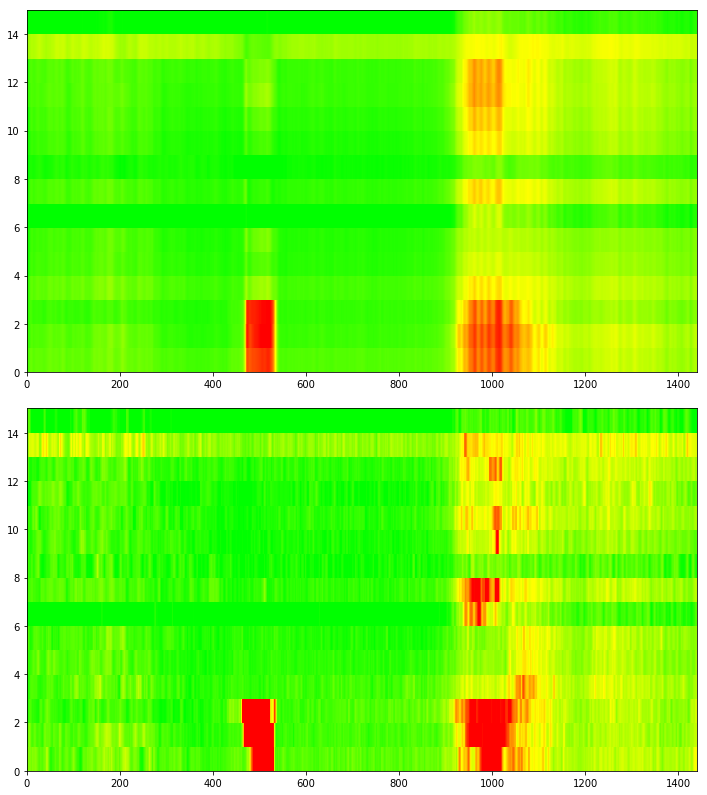

In [10]:
idx = 431  # test: [417,420,431]
out=inference(db[idx],model,step_ahead=1,Min_Max=Min_Max)

gs = gridspec.GridSpec(2, 1, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=(12,14))
ax = plt.subplot(gs[0])
vis_one_day_traffic_speed(out) 
ax = plt.subplot(gs[1])
vis_one_day_traffic_speed(db[idx]['label'])